In [ ]:
   ___       __         ____    _                    ___             _         __ 
  / _ \___ _/ /____ _  / __/___(_)__ ___  _______   / _ \_______    (_)__ ____/ /_
 / // / _ `/ __/ _ `/ _\ \/ __/ / -_) _ \/ __/ -_) / ___/ __/ _ \  / / -_) __/ __/
/____/\_,_/\__/\_,_/ /___/\__/_/\__/_//_/\__/\__/ /_/  /_/  \___/_/ /\__/\__/\__/ 
                                                               |___/              

_by Andrey Mitrofanov_


acknowledging and thankful for valuable contributions to Alexandra Zaykovskaya.

In [187]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sktime.forecasting.ets import AutoETS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sktime.utils.plotting import plot_series

The dataset being used is New Car Sales in Norway: Monthly car sales for 2007-2017 by make and most popular models. [[link]](https://www.kaggle.com/datasets/dmi3kno/newcarsalesnorway)
This project analyzes thend in new auto prices

In [17]:
sales_data = pd.read_csv('norway_new_car_sales_by_make.csv')
for unique_make in list(set(sales_data['Make'])):
    sales_data[unique_make] = sales_data['Quantity'] * (sales_data['Make'] == unique_make)
sales_data = sales_data.groupby(['Year', 'Month'], as_index = False).agg('sum')
sales_data['Date'] = pd.to_datetime(sales_data['Year'].astype(str) + '-' + sales_data['Month'].astype(str)  + '-01')
sales_data = sales_data.drop(columns=['Make', 'Pct', 'Year', 'Month']).rename(columns={'Quantity':'Total'})

Here, I've separated each producer with their number of cars sold in a separate column. This gives the functionality for analysis of every manuracturer separately.

In [18]:
sales_data.head()

,Total,Dodge,Daihatsu,Chevrolet US,Lamborghini,Jeep,Smart,Suzuki,Ford,Fiat,...,Morgan,Dacia,McLaren,Citroen,Tazzari,Ferrari,Hyundai,Lexus,Polaris,Date
0,12685,33,15,0,0,2,1,258,870,9,...,0,0,0,263,0,0,97,22,0,2007-01-01
1,9793,24,22,3,0,6,5,264,686,6,...,0,0,0,247,0,0,149,17,0,2007-02-01
2,11264,25,27,0,0,33,0,333,766,20,...,0,0,0,239,0,0,228,18,0,2007-03-01
3,8854,25,17,0,0,10,1,347,451,7,...,4,0,0,179,0,0,142,18,0,2007-04-01
4,12007,29,36,0,0,72,2,420,648,18,...,2,0,0,223,0,0,155,10,0,2007-05-01


(2) The distinction for manufacturers allows us to visualize sales of each brand separately. I've included a couple examples.

In [19]:
def plot_dynamics(column_name):
    if column_name not in sales_data.columns:
        raise ValueError('the parameter must be \'Total\' or a car manufacturer name')
    fig = go.Figure()
    fig.update_layout(title_text=column_name + ' New Car Sales in Norway')
    fig.add_trace(go.Scatter(x=sales_data['Date'], y=sales_data[column_name]))
    fig.show()
    return None

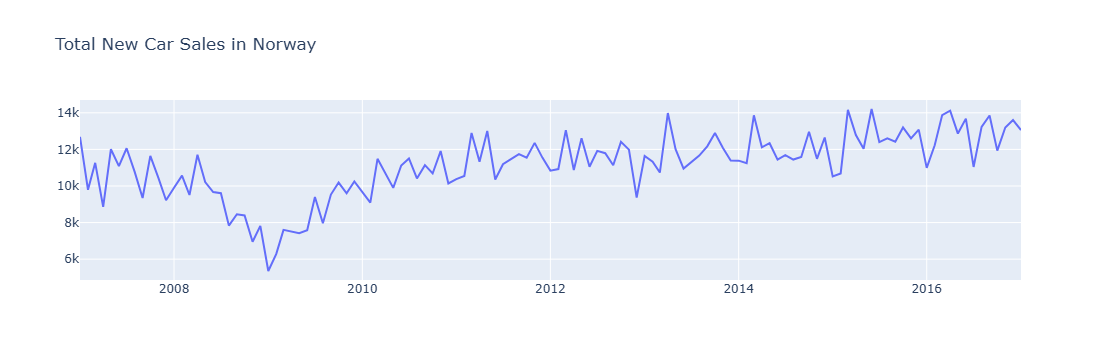

In [20]:
plot_dynamics('Total')

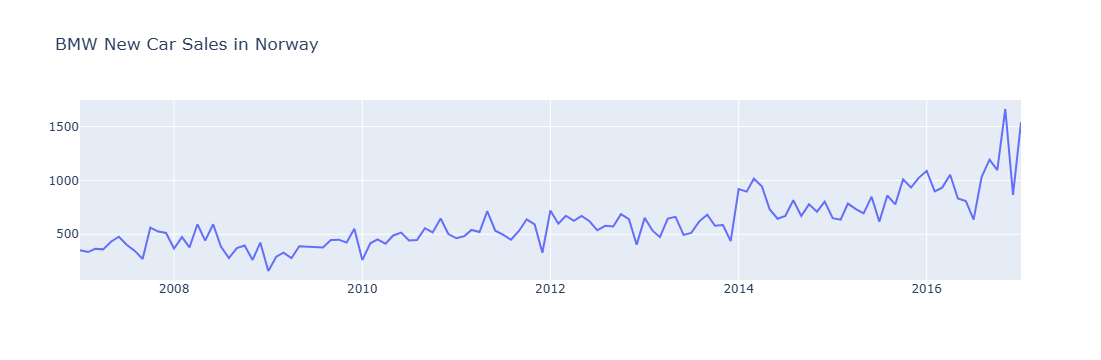

In [21]:
plot_dynamics('BMW')

Now, I hope the next visualizeation falls into the "adding fun" category, because it was very fun to make. By formatting the initial dataframe differently, we can beautifully plot the market share of each manufacturer over time.

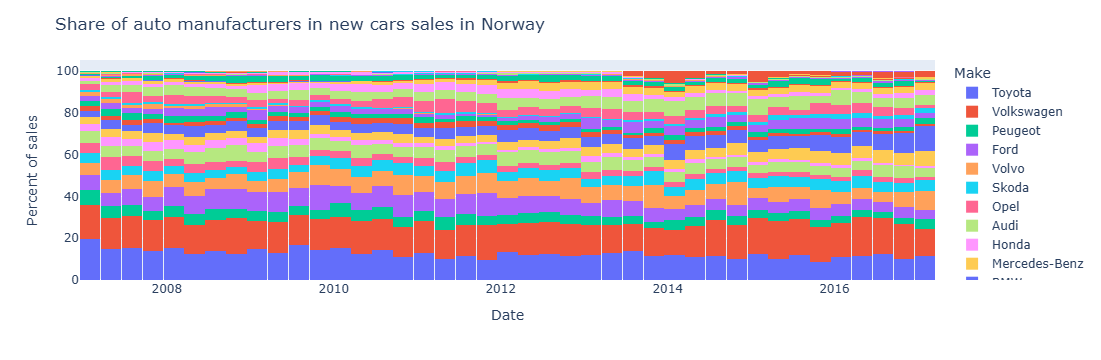

In [22]:
sales_data_for_percent_visualization = pd.read_csv('norway_new_car_sales_by_make.csv')
sales_data_for_percent_visualization['Date'] = pd.to_datetime(sales_data_for_percent_visualization['Year'].astype(str) + '-' + sales_data_for_percent_visualization['Month'].astype(str)  + '-01')
fig = px.histogram(sales_data_for_percent_visualization, x='Date', y='Quantity', color='Make', barnorm='percent', text_auto=False).update_layout(title='Share of auto manufacturers in new cars sales in Norway', yaxis_title="Percent of sales").update_xaxes(categoryorder='total descending')
# Sorry for looooong lines, I usually code of a pretty big monitor, and if the lines don't fit I just extend the screen to my second pretty big monitor. You can use the scroller below. 
fig.show()

(2) Now, I will split the data into train and test parts.

In [23]:
train_data = sales_data.iloc[:int(len(sales_data)*0.8),:]
test_data = sales_data.iloc[int(len(sales_data)*0.8):,:]

(3) Now, I will apply ETS decomposition to the train data. As with visualization, enter any car brand you like or 'Total' to see the ETS decomposition for it.

In [24]:
def ets_decompose(column_name, plot=False):
    if column_name not in sales_data.columns:
        raise ValueError('the parameter must be \'Total\' or a car manufacturer name')
    ets_decomposition = seasonal_decompose(train_data[column_name], model='additive', period=12)
    if plot:
        plt.rcParams.update({'figure.figsize': (16,12)})
        ets_decomposition.plot().suptitle(column_name + ' Car Sales in Norway ETS Decomposition', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        return ets_decomposition

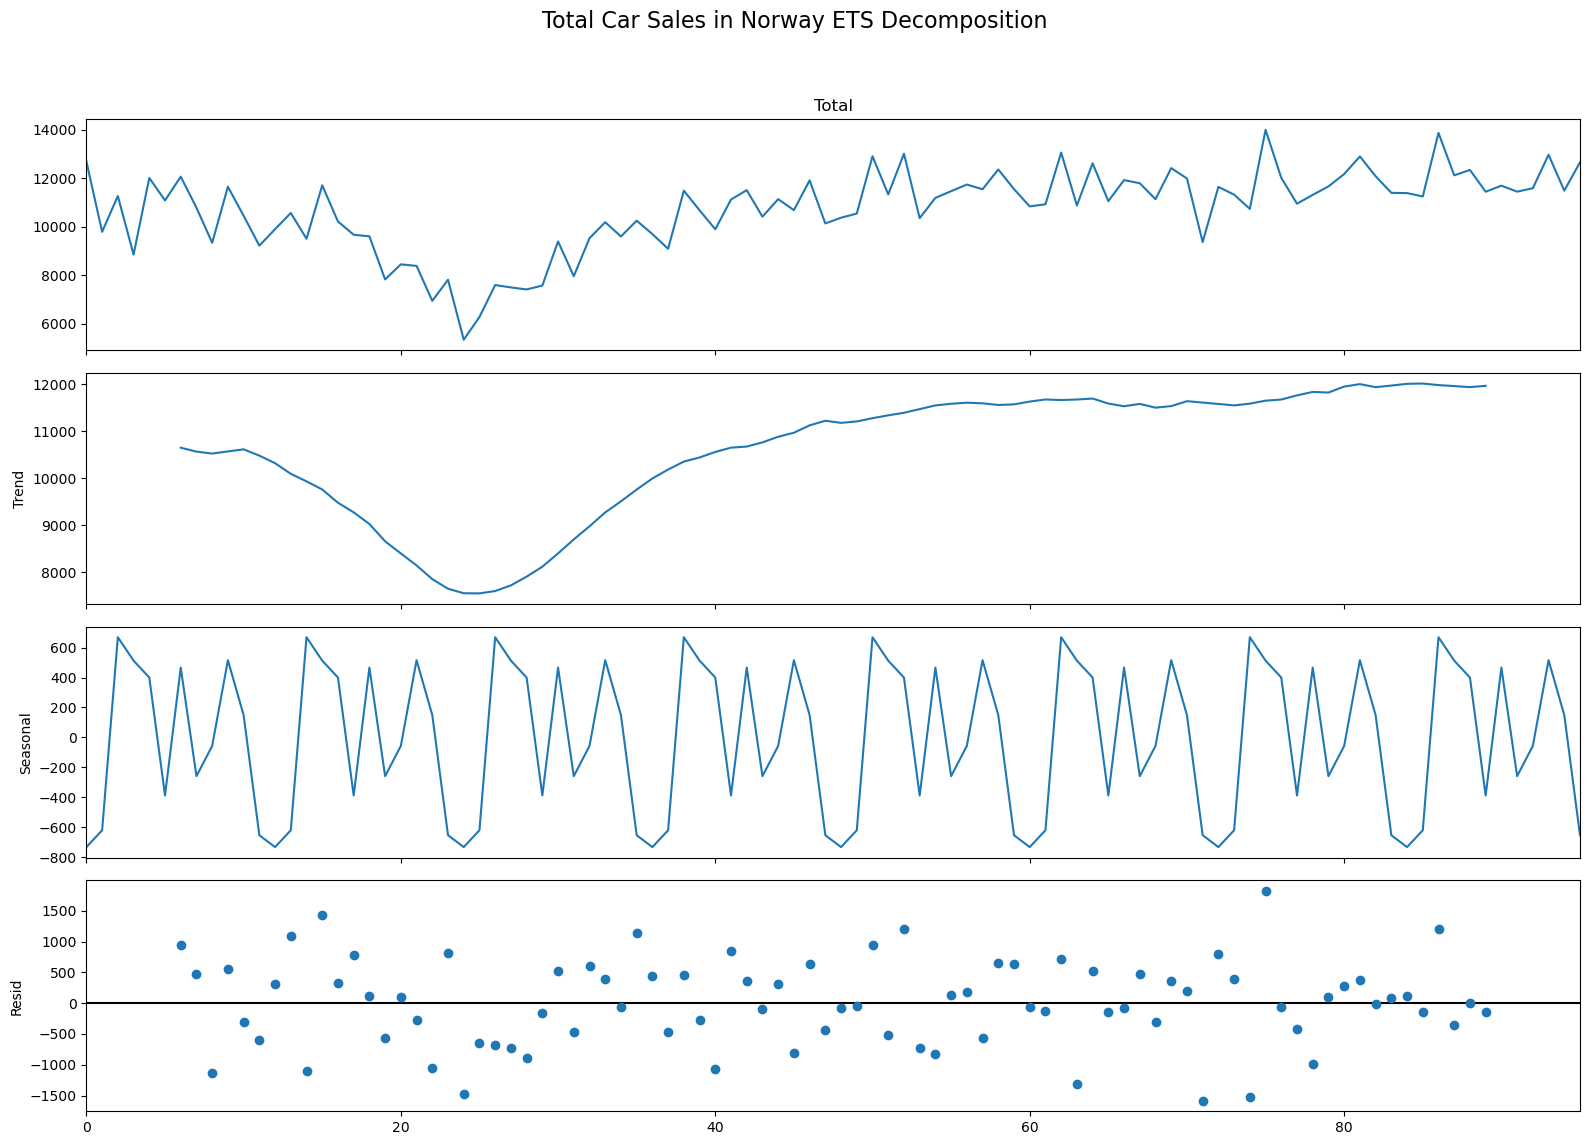

In [27]:
ets_decompose('Total', plot=True)

(4) Here is a lazy function to predict the sales of every brand with Random Forest, works same as previous ones but lacks customizability, works fine withing the scope of this notebook

In [190]:
def predict_random_forest(column_name, plot=False):
    if column_name not in sales_data.columns:
        raise ValueError('the parameter must be \'Total\' or a car manufacturer name')
    clf = DecisionTreeClassifier(max_depth=3, criterion ='entropy')
    random_forest = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth = 10, bootstrap = True)
    random_forest.fit(np.array(train_data['Date']).reshape(-1,1), train_data[column_name])
    quantity_predicted = random_forest.predict(np.array(test_data['Date']).reshape(-1,1))
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=sales_data['Date'], y=sales_data[column_name], name='observed'))
        fig.add_trace(go.Scatter(x=test_data['Date'], y=quantity_predicted, name='Random Forest predicted'))
        fig.update_layout(title_text= 'Random Forest Prediction for ' + column_name + ' New Car Sales in Norway')
        fig.show()
    else:
        return quantity_predicted

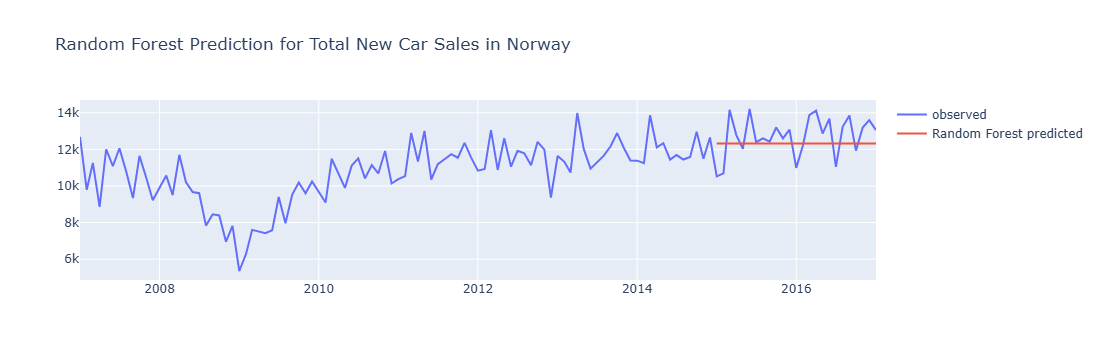

In [191]:
predict_random_forest('Total', plot=True)

This clearly does not work properly, but I have not found a fix yet. The same code seems to work fine with other datasets, but there might be something I do not see. Enough killing time, I will move on

(5) ETS prediction function:

In [166]:
def predict_auto_ETS(column_name, plot=False):
    if column_name not in sales_data.columns:
        raise ValueError('the parameter must be \'Total\' or a car manufacturer name')
    forecaster = AutoETS(error='add', trend='add', seasonal='add', sp=12, n_jobs=-1)
    forecaster.fit(train_data[column_name])
    quantity_predicted = forecaster.predict(np.arange(1, len(test_data)))
    if plot:
        fig=go.Figure()
        fig.add_trace(go.Scatter(x=sales_data['Date'], y=sales_data[column_name], name='observed'))
        fig.add_trace(go.Scatter(x=test_data['Date'], y=quantity_predicted, name='ETS predicted'))
        fig.show()
    else:
        return quantity_predicted

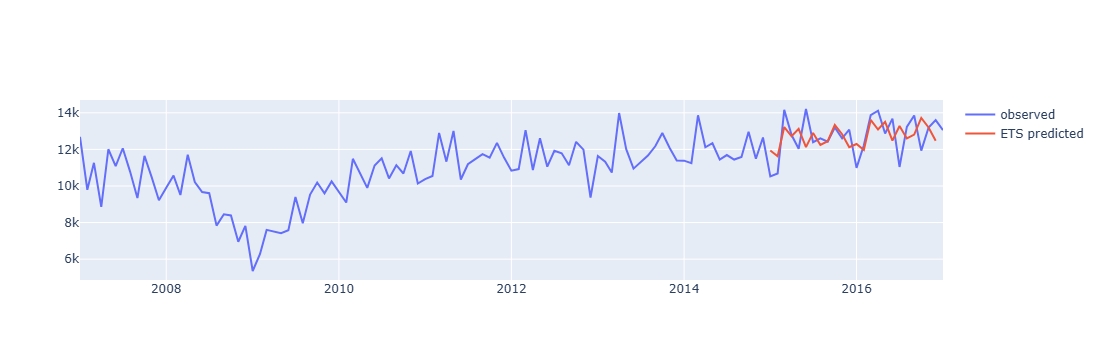

In [165]:
predict_auto_ETS('Total', plot=True)

(6) The obvious choice is the SARIMA model. Looking at the p-values reminded me of [this meme](https://memes.com/m/me-checking-the-gas-prices-please-don-t-be-high-mGRQ3_V-ORv) (except with p-values instead of gas prices), anyways, behold the creation

In [133]:
def predict_SARIMA(column_name, plot=False):
    model=SARIMAX(train_data[column_name],order=(1,1,1),seasonal_order=(1,0,0,12))
    results=model.fit()
    quantity_predicted=results.predict(len(train_data),len(sales_data)).rename('SARIMA Predictions')
    if plot:
        fig=go.Figure()
        fig.add_trace(go.Scatter(x=sales_data['Date'], y=sales_data[column_name], name='observed'))
        fig.add_trace(go.Scatter(x=test_data['Date'], y=quantity_predicted, name='SARIMA predicted'))
        fig.show()
    else:
        return quantity_predicted

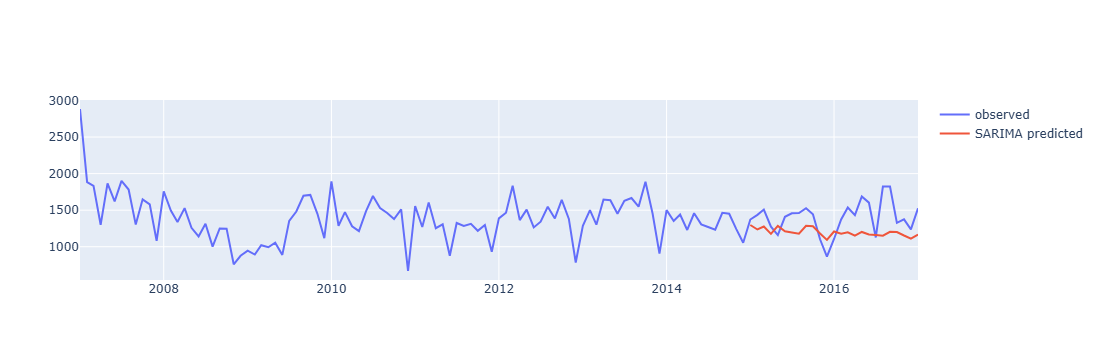

In [145]:
predict_SARIMA('Toyota', True)

(7) for the final challenge, let us simply compare the squared error from the three models and see which one is the lowest

In [171]:
SARIMA_se, ETS_se, RF_se = np.array([]), np.array([]), np.array([])
for column_name in ['Jeep', 'Total', 'BMW']:
    if column_name != 'Date':
        SARIMA_se = np.append(SARIMA_se, np.sum((test_data[column_name] - predict_SARIMA(column_name)) ** 2))
        ETS_se = np.append(ETS_se, np.sum((test_data[column_name] - predict_auto_ETS(column_name)) ** 2))
        RF_se = np.append(RF_se, np.sum((test_data[column_name] - predict_random_forest(column_name)) ** 2))
print('Random Forest')
print('mean:', round(np.mean(RF_se),2), 'std: ', round(np.std(RF_se),2))
print('-'*36)
print('ETS')
print('mean:', round(np.mean(ETS_se),2), 'std: ', round(np.std(ETS_se),2))
print('-'*36)
print('SARIMA')
print('mean:', round(np.mean(SARIMA_se),2), 'std: ', round(np.std(SARIMA_se),2))
print('-'*36)

Random Forest
mean: 10013464.33 std:  12776932.36
------------------------------------
ETS
mean: 8096991.22 std:  10655439.24
------------------------------------
SARIMA
mean: 11172079.01 std:  14578526.39
------------------------------------


This way we have concluded that ETS gives us a lower squared error, thus, it is the better model out of the three. Maybe Random Forest would be better if it worked, wwho knows.



                                     \ / \/ \/ / ,
                                   \ /  \/ \/  \/  / ,
                                 \ \ \/ \/ \/ \ \/ \/ /
                               .\  \/  \/ \/ \/  \/ / / /
                              '  / / \/  \/ \/ \/  \/ \ \/ \
                           .'     ) \/ \/ \/ \/  \/  \/ \ / \
                          /   o    ) \/ \/ \/ \/ \/ \/ \// /
                        o'_ ',__ .'   ,.,.,.,.,.,.,.,'- '/the 
                                 // \\          // \\        end
                                ''  ''         ''  ''